# Tutorial 9: Part 4

In [1]:
#import required libraries
import numpy as np
import matplotlib.pyplot as plt
from minisom import MiniSom
import pandas as pd
import pickle
from sklearn.decomposition import PCA

## Example 4: SLP Data
This is the same data as from Tutorial 4 on PCA -- gridded daily sea-level pressure data for North Pacific from CFSR climate reanalysis.  Period: 1 Jan 1979 through 31 Dec 2010.  

NOTE: This takes a few minutes to run

In [2]:
#load sea level pressure data
#NOTE: The sea level pressure file is large (>100MB), so you will have to download it and change the path here

#change 'SLP_directory' to wherever you've saved the SLP file
SLP_directory = '/Users/samanderson/Desktop/MATLAB/Teaching/EOSC_410/Valentina_files/Tutorial4_2018/'
SLP_filename = 'SLP_CFSR_daily_200km_cropped_1979_2010.csv'
SLP = pd.read_csv(SLP_directory + SLP_filename,header=None)

#rows 0 and 54 are all NaN -- fill with adjacent values 
SLP.iloc[0] = SLP.iloc[1]
SLP.iloc[54] = SLP.iloc[53]

In [3]:
#load useful data for making plots and unpack into individual variables 
pickle_in = open("coordinates_for_plots.pickle","rb")
coordinates_for_plots_dict = pickle.load(pickle_in)

dx = coordinates_for_plots_dict['dx'][0][0]
Nx = coordinates_for_plots_dict['Nx'][0][0]
Ny = coordinates_for_plots_dict['Ny'][0][0]
x_coast_NARR = coordinates_for_plots_dict['x_coast_NARR'][0]
x_dom = coordinates_for_plots_dict['x_dom'][0]
x_domp = coordinates_for_plots_dict['x_domp'][0]
x_GCM = coordinates_for_plots_dict['x_GCM'][0]
x_NARR = coordinates_for_plots_dict['x_NARR']
xE = coordinates_for_plots_dict['xE'][0]
xW = coordinates_for_plots_dict['xW'][0]
y_coast_NARR = coordinates_for_plots_dict['y_coast_NARR'][0]
y_dom = coordinates_for_plots_dict['y_dom'][0]
y_domp = coordinates_for_plots_dict['y_domp'][0]
y_GCM = coordinates_for_plots_dict['y_GCM'][0]
y_NARR = coordinates_for_plots_dict['y_NARR']
yN = coordinates_for_plots_dict['yN'][0]
yS = coordinates_for_plots_dict['yS'][0]
incrop = pd.read_csv('incrop.csv',header=None)

/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  import sys


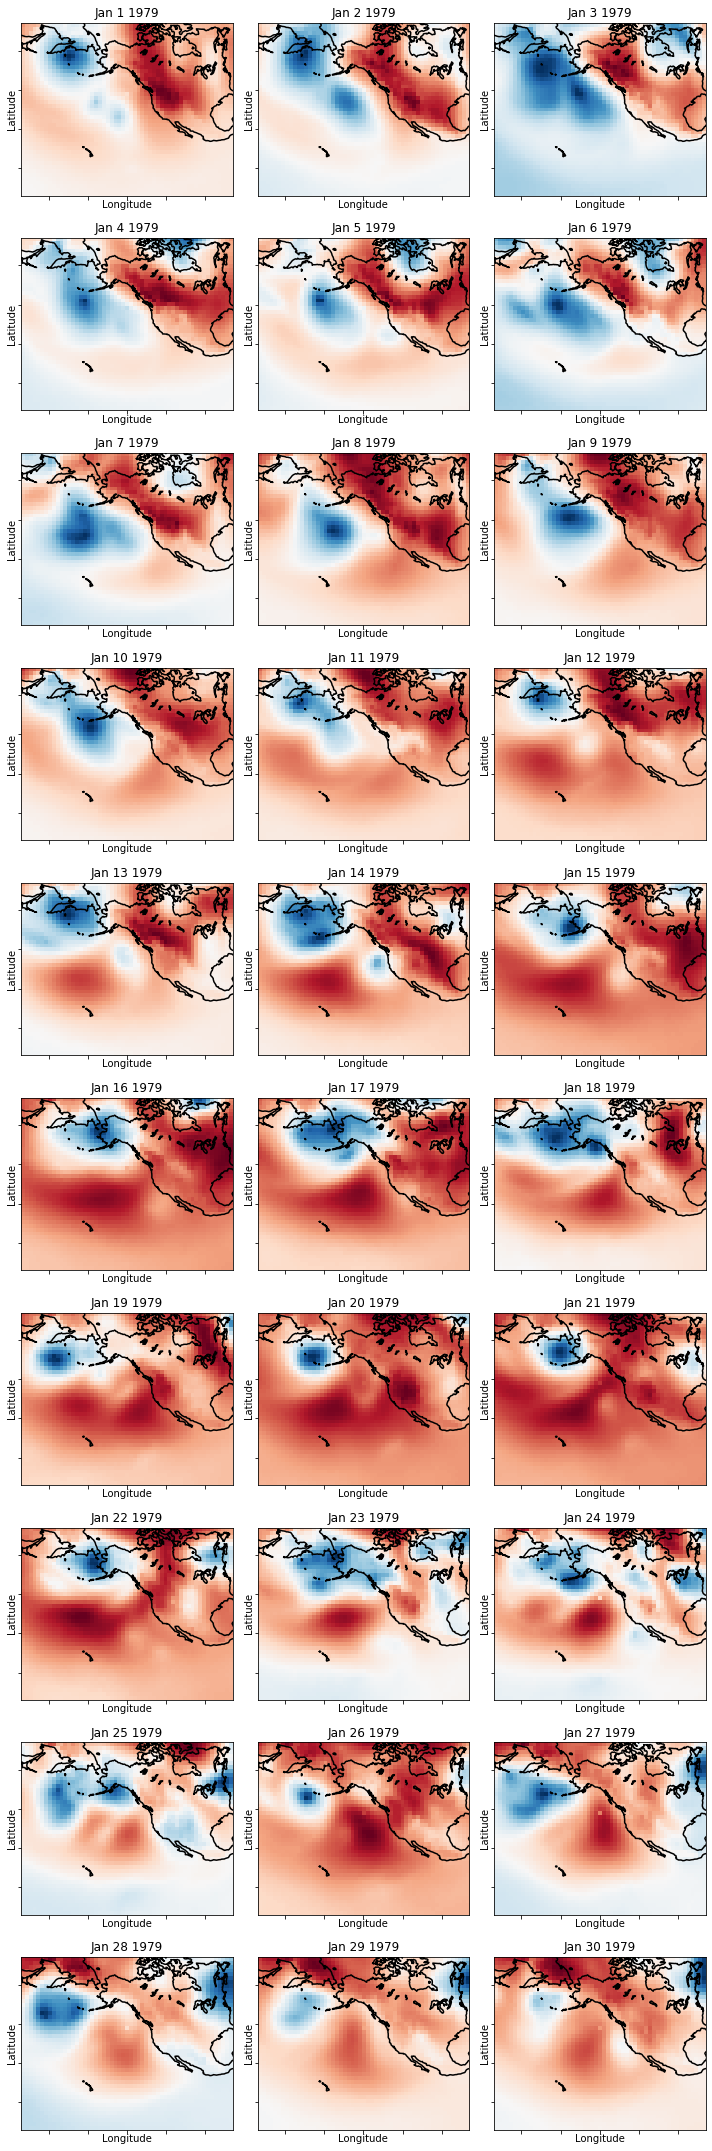

In [4]:
#try plotting the data for January 1979 to see what we're working with

plt.figure(figsize=(10,30))

for ii in range(30):
    
    SLP_plot = np.reshape(SLP[ii].get_values(),(Ny,Nx))
    extent = [np.nanmin(x_NARR), np.nanmax(x_NARR), np.nanmin(y_NARR), np.nanmax(y_NARR)]
    
    plt.subplot(10,3,ii+1)
    plt.imshow(np.flipud(SLP_plot),extent = extent,cmap='RdBu_r')
    plt.plot(x_coast_NARR,y_coast_NARR,color='k')
    
    plt.title('Jan '+str(ii+1)+' 1979')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.xlim((np.nanmin(x_NARR), np.nanmax(x_NARR)))
    plt.ylim((np.nanmin(y_NARR), np.nanmax(y_NARR)))
    plt.tick_params(labelbottom=False, labelleft=False)

plt.tight_layout()
plt.show()

In [5]:
#now, do PCA

n_modes = np.min(np.shape(SLP))
pca = PCA(n_components = n_modes)
PCs = pca.fit_transform(SLP.T)
eigvecs = pca.components_
fracVar = pca.explained_variance_ratio_

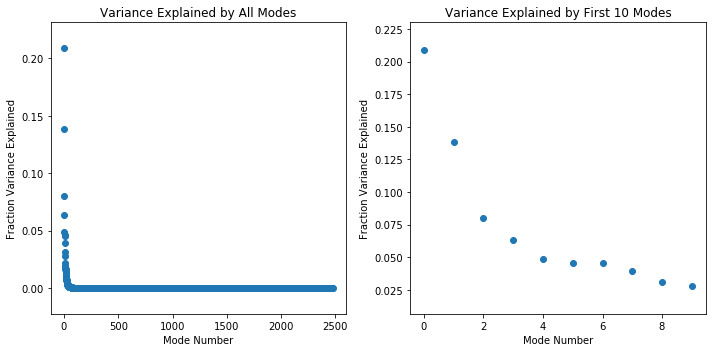

In [6]:
#plot fraction of variance explained by each mode

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.scatter(range(len(fracVar)),fracVar)
plt.xlabel('Mode Number')
plt.ylabel('Fraction Variance Explained')
plt.title('Variance Explained by All Modes')

plt.subplot(1,2,2)
n_modes_show = 10
plt.scatter(range(n_modes_show),fracVar[:n_modes_show])
plt.xlabel('Mode Number')
plt.ylabel('Fraction Variance Explained')
plt.title('Variance Explained by First ' + str(n_modes_show) + ' Modes')

plt.tight_layout()

plt.show()

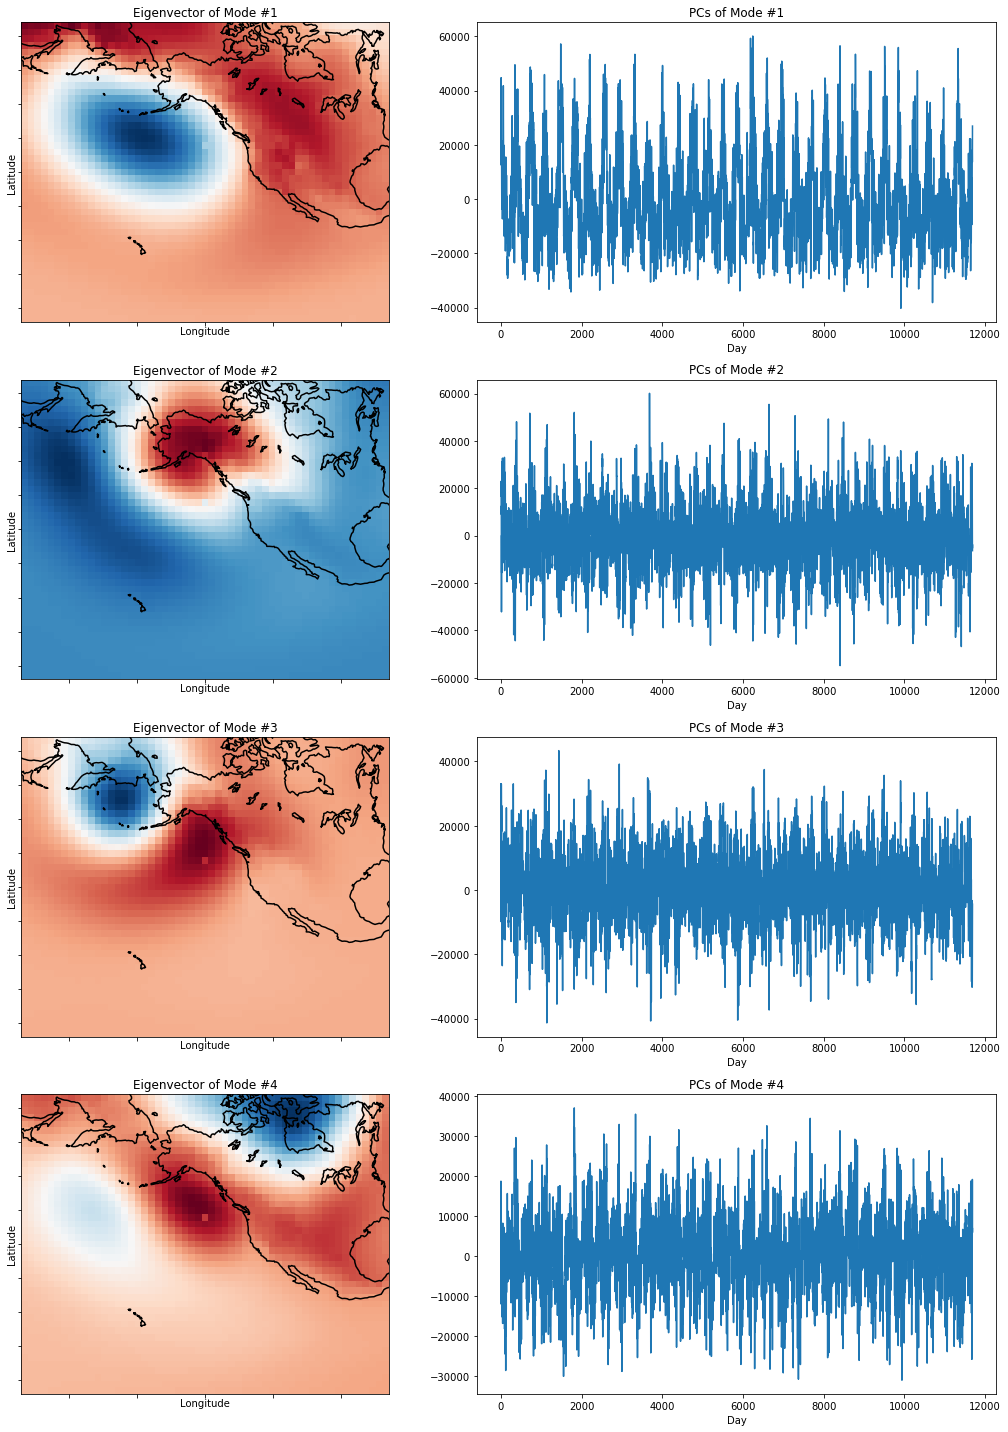

In [7]:
#plot the first n modes and PCs -- choose a value of 'n' from the variance explained figure!

n = 4

plt.figure(figsize=(15,5*n))
for kk in range(n):
    
    plt.subplot(n,2,kk*2+1)
    plt.imshow(np.flipud(np.reshape(eigvecs[kk],(Ny,Nx))),extent = extent,cmap='RdBu_r')
    plt.plot(x_coast_NARR,y_coast_NARR,color='k')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.xlim((np.nanmin(x_NARR), np.nanmax(x_NARR)))
    plt.ylim((np.nanmin(y_NARR), np.nanmax(y_NARR)))
    plt.tick_params(labelbottom=False, labelleft=False)
    plt.title('Eigenvector of Mode #' + str(kk+1))
    
    plt.subplot(n,2,(kk+1)*2)
    plt.plot(PCs[:,kk])
    plt.title('PCs of Mode #' + str(kk+1))
    plt.xlabel('Day')
    
plt.tight_layout()

In [42]:
#run SOM -- this code creates/trains the SOM and calculates stats of interest

nx = 3
ny = 3
N = 5000 #number of days to use as input to the SOM -- there are over 10,000 days in SLP, but this takes a long time to run
data = SLP.T[-N:].get_values()

#make, initialize, and train the SOM
som = MiniSom(nx, ny, len(data[0]), sigma=1., learning_rate=0.5) # initialization of (ny x nx) SOM
som.pca_weights_init(data)
som.train_random(data, 100) # trains the SOM

qnt = som.quantization(data) #this is the pattern of the BMU of each observation (ie: has same size as data input to SOM)
bmu_patterns = som.get_weights() #this is the pattern of each BMU; size = (nx, ny, len(data[0]))
QE = som.quantization_error(data) #quantization error of map
TE = som.topographic_error(data) #topographic error of map

#calculate the BMU of each observation
bmus = []
bmus_num = []
for kk in range(len(data)):
    bmus.append(som.winner(data[kk]))
    num = bmus[kk][0]*nx + bmus[kk][1]
    bmus_num.append(num)
    
#inds gives the sequential coordinates of each SOM node (useful for plotting)
inds = []
for ii in range(ny):
    for jj in range(nx):
        inds.append((ii,jj))
     
#compute the frequency of each BMU
freq = np.zeros((nx,ny))
for bmu in bmus:
    freq[bmu[0]][bmu[1]]+=1
freq/=N

/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.values' or 'np.asarray(..)' instead.
  


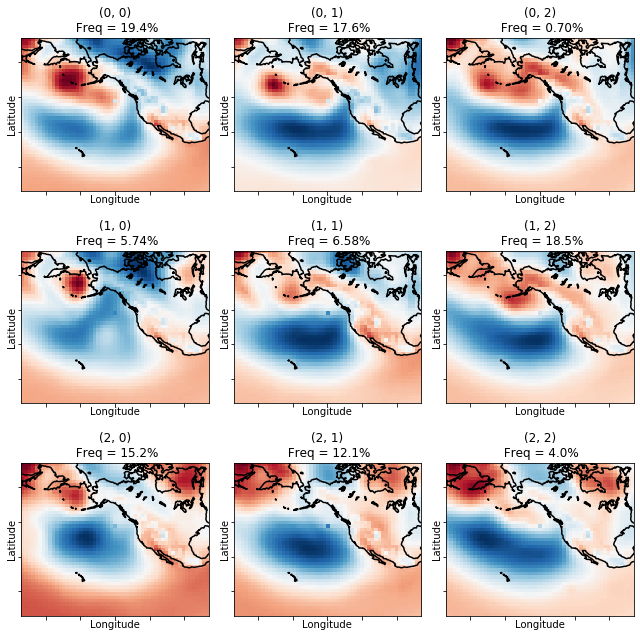

In [43]:
#visualize

extent = [np.nanmin(x_NARR), np.nanmax(x_NARR), np.nanmin(y_NARR), np.nanmax(y_NARR)]

plt.figure(figsize=(3*nx,3*ny))
for kk in range(nx*ny):   
    plt.subplot(ny,nx,kk+1)
    indx = inds[kk][1]
    indy = inds[kk][0]
    plt.imshow(np.flipud(np.reshape(bmu_patterns[indx][indy],(Ny,Nx))),cmap='RdBu',extent=extent)
    plt.plot(x_coast_NARR,y_coast_NARR,color='k')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.xlim((np.nanmin(x_NARR), np.nanmax(x_NARR)))
    plt.ylim((np.nanmin(y_NARR), np.nanmax(y_NARR)))
    plt.tick_params(labelbottom=False, labelleft=False)
    plt.title(str(inds[kk]) + '\n Freq = ' + str(freq[indx][indy]*100)[:4] + '%')
    
plt.tight_layout()

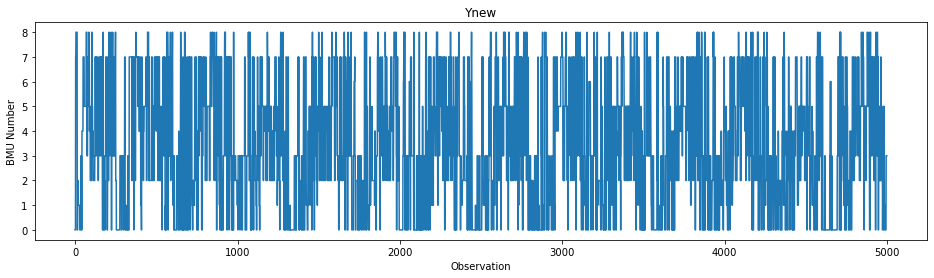

In [47]:
#visualize clustered data
plt.figure(figsize=(16,4))
plt.plot(bmus_num)
plt.xlabel('Observation')
plt.ylabel('BMU Number')
plt.title('Ynew')
plt.show()